# ARIMA 

## Import the data and the librarires

In [1]:
import os
cwd = os.getcwd()
print(cwd)

chdir=os.chdir("D:\Folder D/New folder/WERK Student/EXCEL/")
print(chdir)

C:\Users\alihi
None


In [41]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
import pmdarima as pm
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
%matplotlib inline
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic

In [42]:
df = pd.read_csv('201102_DataSet Forecast_0.01.csv',sep=';',
                 header=0, parse_dates = ['transaction_date'], index_col = ['transaction_date'])

## Explorarty Data Analysis

In [4]:
df.head()

,warehouse_id,product_id,quantity
transaction_date,,,
1998-01-01,10,4,3
1998-01-01,10,11,3
1998-01-01,10,12,3
1998-01-01,10,14,2
1998-01-01,10,16,3


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 182883 entries, 1998-01-01 to 1998-12-30
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   warehouse_id  182883 non-null  int64
 1   product_id    182883 non-null  int64
 2   quantity      182883 non-null  int64
dtypes: int64(3)
memory usage: 5.6 MB


In [6]:
# Choose the highest demanded Ware House
print(df.warehouse_id.value_counts())

12    13215
8     13014
19    12770
13    12518
17    12416
21    12337
15     9491
16     9120
11     9022
10     8744
3      8722
7      8519
1      8473
24     8455
4      8267
6      7960
9      3817
18     3469
23     3455
20     3321
22     1478
5      1470
14     1441
2      1389
Name: warehouse_id, dtype: int64


In [7]:
# Choose the Highest Demanded peoduct from the 12 warehouse
df12=df[df['warehouse_id']==12]
print(df12.product_id.value_counts())
df342=df12[df12['product_id']==342]
print(df342.shape)
print(df342.columns)
df342=df342.drop(['warehouse_id','product_id'],axis=1)

342     23
846     22
942     19
856     18
1337    18
        ..
1303     2
780      2
1227     2
922      2
1082     1
Name: product_id, Length: 1559, dtype: int64
(23, 3)
Index(['warehouse_id', 'product_id', 'quantity'], dtype='object')


In [8]:
print(df342.head())
print(df342.shape)

                  quantity
transaction_date          
1998-01-05               2
1998-01-07               2
1998-02-01               3
1998-03-19               2
1998-03-21               2
(23, 1)


## Apply forecasting on the df342

### Check the Stationarity of the df342, and have an assumed(p.d.q)

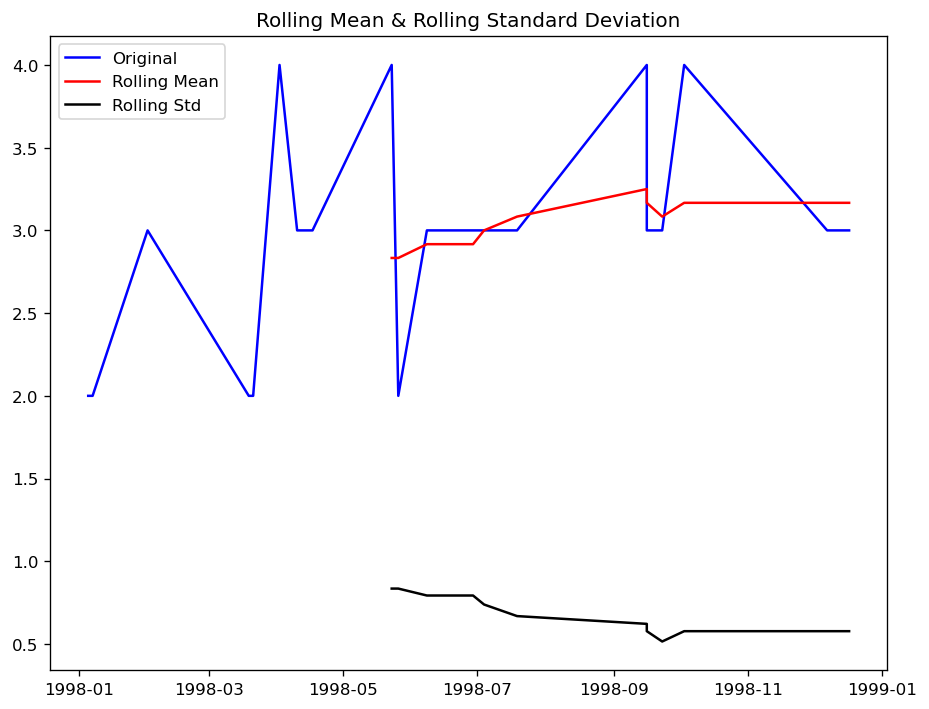

In [9]:
rolling_mean = df342.rolling(window = 12).mean()
rolling_std = df342.rolling(window = 12).std()
plt.plot(df342, color = 'blue', label = 'Original')
plt.plot(rolling_mean['quantity'], color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std['quantity'], color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [10]:
# Applying adfuller test, with the null hypothesis if the p/values is less than 0.05 it means that it is stationary
result = adfuller(df342)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))
    # the model is stationary , and we don't need to differentiate at all the d=0

ADF Statistic: -3.8979725450074456
p-value: 0.0020498188280757947
Critical Values:
	1%: -3.769732625845229
	5%: -3.005425537190083
	10%: -2.6425009917355373


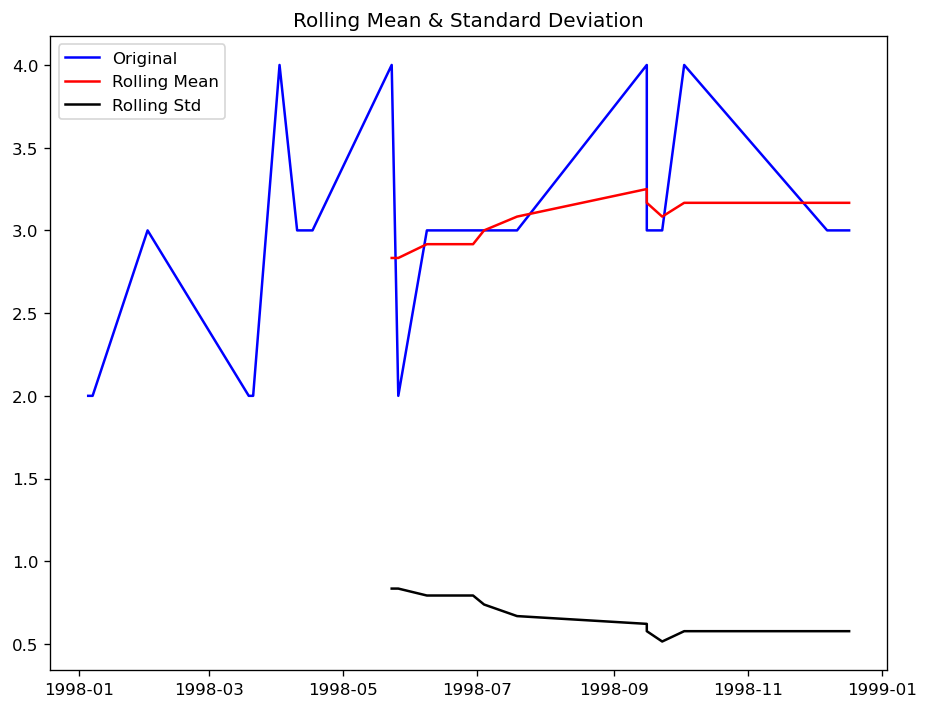

ADF Statistic: -3.8979725450074456
p-value: 0.0020498188280757947
Critical Values:
	1%: -3.769732625845229
	5%: -3.005425537190083
	10%: -2.6425009917355373


In [11]:
# Applying the previous two cells in a function
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['quantity'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
        
get_stationarity(df342)

In [12]:
# Remove the time index, so we can plot
df342.reset_index(inplace=True)
print(df342.head())

  transaction_date  quantity
0       1998-01-05         2
1       1998-01-07         2
2       1998-02-01         3
3       1998-03-19         2
4       1998-03-21         2


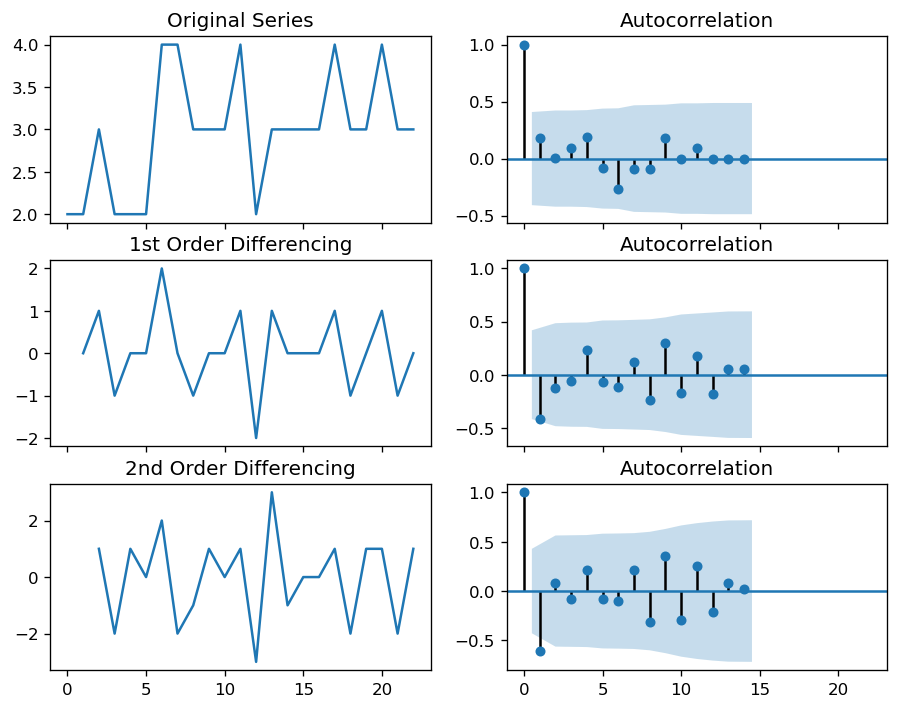

In [13]:
#The right order of differencing is the minimum differencing required to get a near-stationary series which 
#roams around a defined mean and the ACF plot reaches to zero fairly quick.
#If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative,
#then the series is probably over-differenced.

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df342.quantity); axes[0, 0].set_title('Original Series')
plot_acf(df342.quantity, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df342.quantity.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df342.quantity.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df342.quantity.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df342.quantity.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

C:\Users\alihi\anaconda3\envs\ML\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


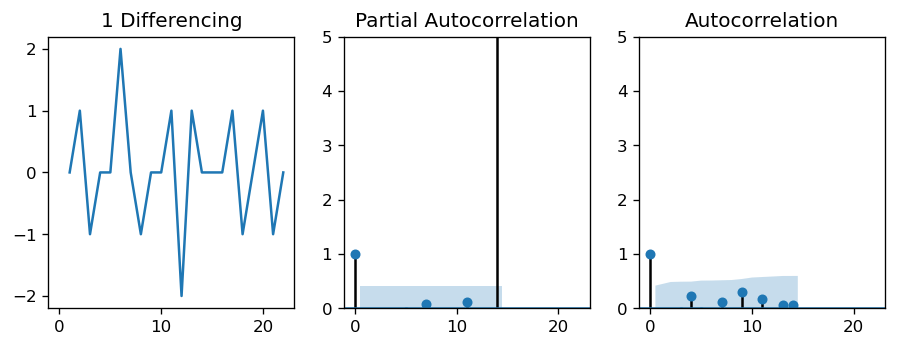

In [14]:
# Select the best P,we can get it by ploting the PACF , but also ACF is helpful
# PACF plot of 1 differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 3, sharex=True)
axes[0].plot(df342.quantity.diff()); axes[0].set_title('1 Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df342.quantity.diff().dropna(), ax=axes[1])
axes[2].set(ylim=(0,5))
plot_acf(df342.quantity.diff().dropna(), ax=axes[2])

plt.show()
# I believe that i can select p=1 because in the ACF , it seems it starts to tail off in the 1 lag

C:\Users\alihi\anaconda3\envs\ML\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


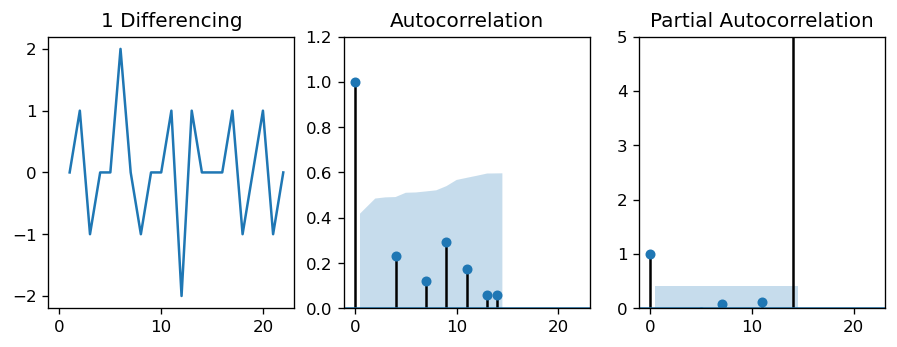

In [15]:
# Select the best q, we can get it by ploting the ACF , but also PACF is helpful
fig, axes = plt.subplots(1, 3, sharex=True)
axes[0].plot(df342.quantity.diff()); axes[0].set_title('1 Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df342.quantity.diff().dropna(), ax=axes[1])
axes[2].set(ylim=(0,5))
plot_pacf(df342.quantity.diff().dropna(), ax=axes[2])

plt.show()
# I believe that i can select q=1 because in the PACF , it seems it starts to tail off in the 0 lag

In [16]:
#If your series is slightly under differenced, adding one or more additional AR terms usually makes it up. Likewise,
#if it is slightly over-differenced, try adding an additional MA term.

# 1,0,1 ARIMA Model
model = ARIMA(df342.quantity, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.quantity   No. Observations:                   22
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -26.354
Method:                       css-mle   S.D. of innovations              0.799
Date:                Wed, 04 Nov 2020   AIC                             58.709
Time:                        09:29:43   BIC                             61.982
Sample:                             1   HQIC                            59.480
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0467      0.123      0.378      0.705      -0.195       0.289
ar.L1.D.quantity    -0.3980      0.188     -2.113      0.035      -0.767      -0.029
                            

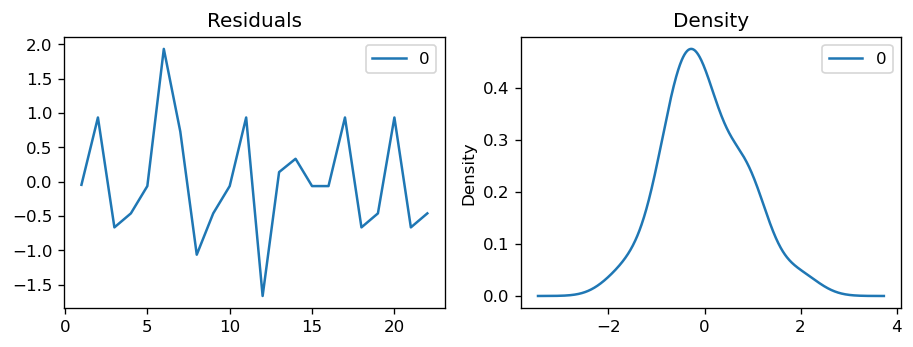

In [17]:
#Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

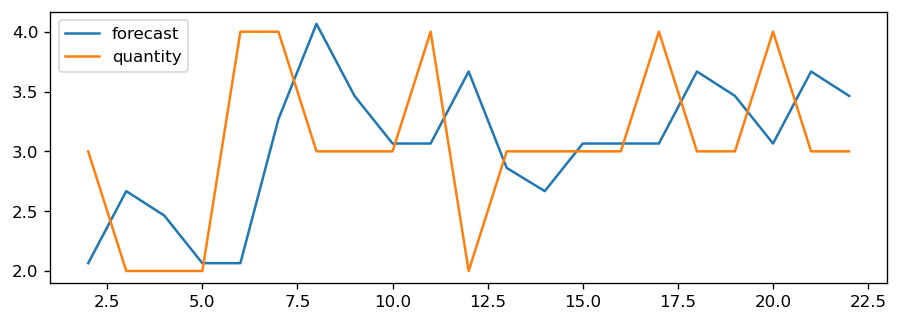

In [18]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()
#When you set dynamic=False the in-sample lagged values are used for prediction

### Try other number of p.d.q

In [19]:
# Now we will do the Cross -Validation Times series decomposition
# Create Training and Test
train = df342.quantity[:17]
test = df342.quantity[17:]

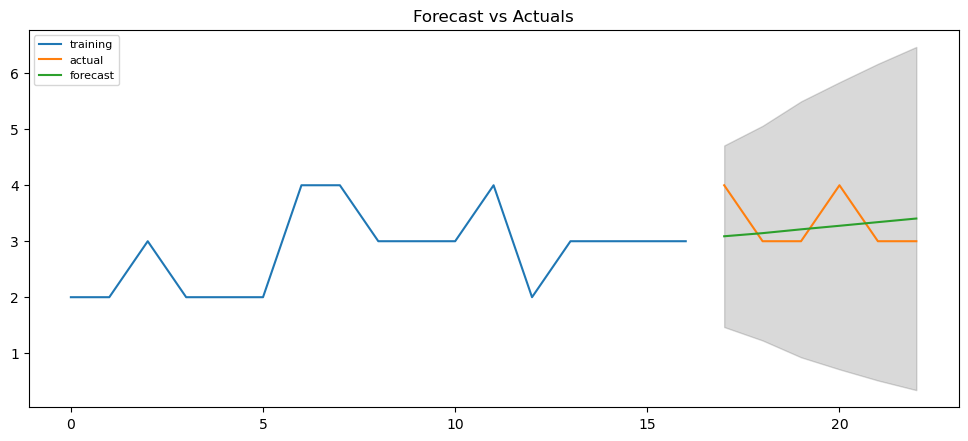

In [20]:
# Build Model, to see if we applied the previous assumed p.d.q how the forecast will be  
model = ARIMA(train, order=(1, 1, 0))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(6, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [21]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

C:\Users\alihi\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'mape': 0.12944030993310895,
 'me': -0.08872901997443587,
 'mae': 0.45647092262415007,
 'mpe': -0.006859675716537547,
 'rmse': 0.5325650629239111,
 'acf1': -0.22581976921418087,
 'corr': -0.40403711499301004,
 'minmax': 0.12367653562458214}

                             ARIMA Model Results                              
Dep. Variable:            D2.quantity   No. Observations:                   15
Model:                 ARIMA(3, 2, 0)   Log Likelihood                 -21.045
Method:                       css-mle   S.D. of innovations              0.930
Date:                Wed, 04 Nov 2020   AIC                             52.091
Time:                        09:29:44   BIC                             55.631
Sample:                             2   HQIC                            52.053
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0081      0.082      0.100      0.920      -0.152       0.168
ar.L1.D2.quantity    -0.9556      0.203     -4.703      0.000      -1.354      -0.557
ar.L2.D2.quantity    -0.

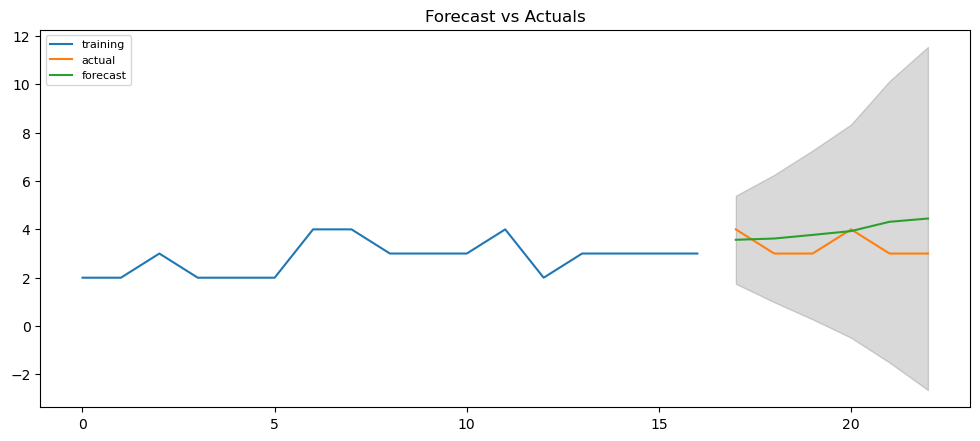

In [22]:
#So, what I am going to do is to increase the order of differencing to two, that is set d=2 and iteratively increase p to up to 5 and then q up to 5 to see which model gives least AIC 
#and also look for a chart that gives closer actuals and forecasts
#While doing this, I keep an eye on the P values of the AR and MA terms in the model summary.
#They should be as close to zero, ideally, less than 0.05.

# I think i have to build a for loop to figure out which one is the best, along low AIC and BIC
# Build Model
model = ARIMA(train, order=(3, 2, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(6, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [23]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': 0.2516741008563374,
 'me': 0.6085736781212511,
 'mae': 0.775943534632978,
 'mpe': 0.20983163672840566,
 'rmse': 0.9122508032161861,
 'acf1': -0.003057815640085797,
 'corr': -0.40958254172415215,
 'minmax': 0.18858719440057603}

### Apply Cross Validation to get the best (p.d.q) of df342

In [30]:
#auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters
#and chooses the best model that has the least AIC.

model = pm.auto_arima(df342.quantity, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=60.702, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=58.709, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58.761, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=57.545, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=56.165, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=58.125, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=54.914, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=55.872, Time=0.01 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=56.913, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=56.913, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=55.603, Time=0.04 sec
 ARIMA(4,

0.577434661065441


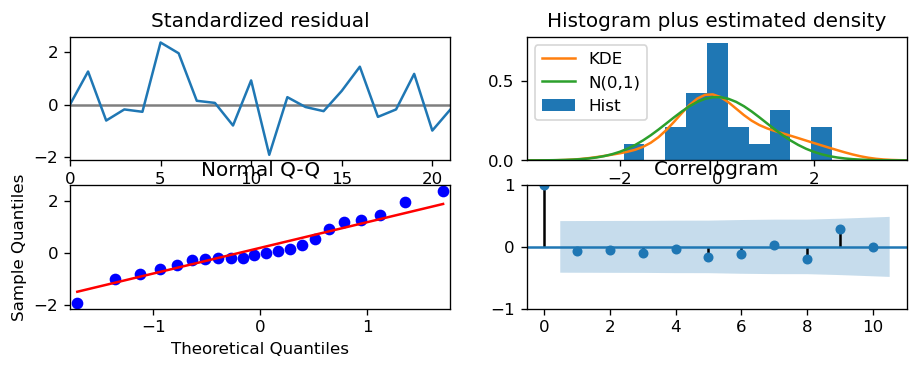

In [25]:
#Model Diagnostic: it is a way to check if the model selected is the best 
#we see the residuals of the model  by mean absolute error , that it should be uncorrelated white noise gaussian , noise centered on zero
# Fit model
model = sm.tsa.statespace.SARIMAX(df342.quantity, order=(3,1,0))
results = model.fit()
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))
# Print mean absolute error
print(mae)
results.plot_diagnostics()
plt.show()

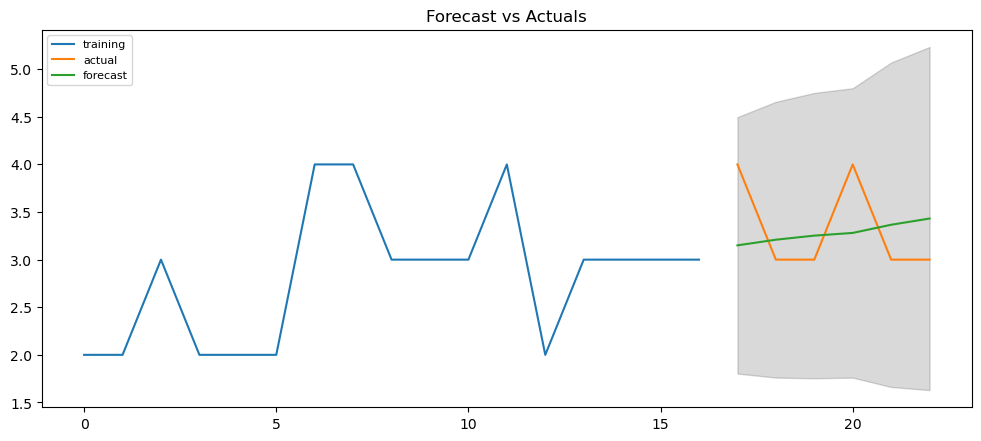

In [26]:
# Build Model, to see if we applied the previous assumed p.d.q how the forecast will be  
model = ARIMA(train, order=(3, 1, 0))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(6, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [27]:
print('the predicted ones',fc)
print('the real values are',test.values)

the predicted ones [3.15006396 3.20936348 3.25228751 3.28050247 3.36635275 3.43171919]
the real values are [4 3 3 4 3 3]


In [28]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

# Around 13.5% MAPE implies the model is about 86.5% accurate in predicting the next 6 observations.

C:\Users\alihi\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'mape': 0.1353776726974044,
 'me': -0.05161843764237428,
 'mae': 0.4715260831971542,
 'mpe': 0.00459154248752226,
 'rmse': 0.5272800981466833,
 'acf1': -0.2476383531985182,
 'corr': -0.4993358022716578,
 'minmax': 0.12829938615422531}

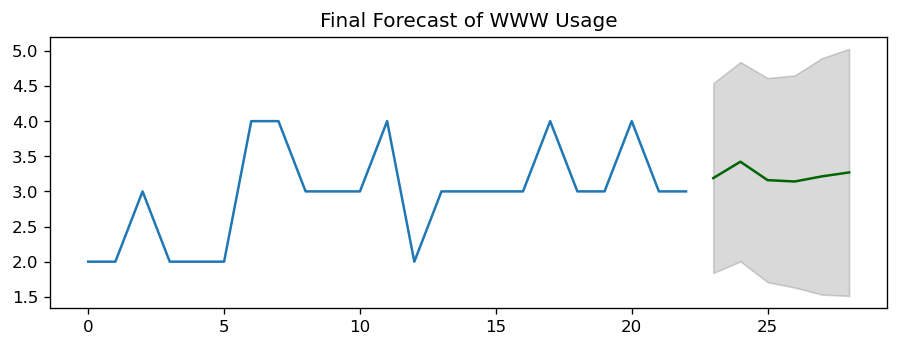

In [31]:
# Forecast
n_periods = 6
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df342.quantity), len(df342.quantity)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df342.quantity)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

In [43]:
# Remove the time index, so we can plot
#df.reset_index(inplace=True)
print(df.head())

                  warehouse_id  product_id  quantity
transaction_date                                    
1998-01-01                  10           4         3
1998-01-01                  10          11         3
1998-01-01                  10          12         3
1998-01-01                  10          14         2
1998-01-01                  10          16         3


## Applying VAR ( multiVariate time series) on the Whole Data

In [45]:
print(df.head())
print(df.shape)

                  warehouse_id  product_id  quantity
transaction_date                                    
1998-01-01                  10           4         3
1998-01-01                  10          11         3
1998-01-01                  10          12         3
1998-01-01                  10          14         2
1998-01-01                  10          16         3
(182883, 3)


### Plot each column

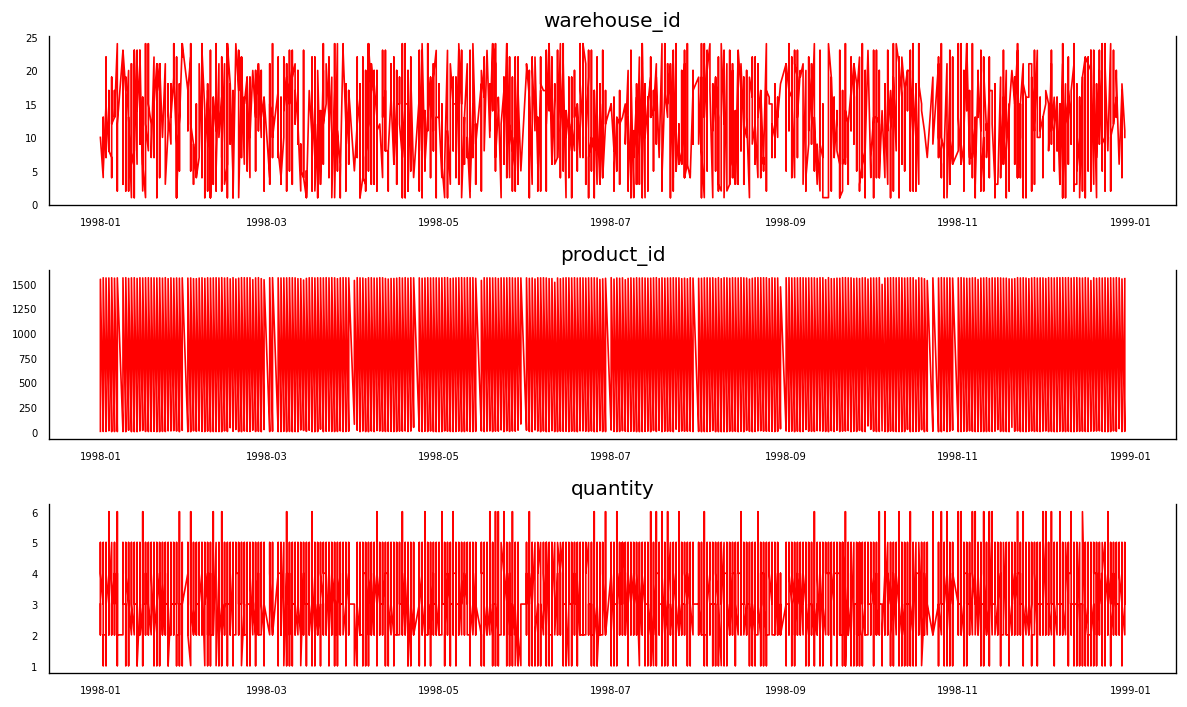

In [46]:
# Plot
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### See the Causality of each column with others

In [47]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

C:\Users\alihi\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,warehouse_id_x,product_id_x,quantity_x
warehouse_id_y,1.0000,0.2306,0.0783
product_id_y,0.2574,1.0000,0.0101
quantity_y,0.7356,0.0000,1.0000


### Cointegration to see if there is relationship

In [48]:
#If a given p-value is < significance level (0.05), then,
#the corresponding X series (column) causes the Y (row).
# for example row 1 column 2 = 0.2306 which means that product id causes warehouse id

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

#When two or more time series are cointegrated,
#it means they have a long run, statistically significant relationship.

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
warehouse_id ::  13182.83  > 24.2761   =>   True
product_id ::  1902.28   > 12.3212   =>   True
quantity ::  128.12    > 4.1296    =>   True


### Train , test split

In [49]:
df_train = df[:137162]
df_test = df[137162:]
# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)

(137162, 3)
(45721, 3)


In [58]:
print(df_train[-3:])

                  warehouse_id  product_id  quantity
transaction_date                                    
1998-10-08                  17         878         4
1998-10-08                  17         883         2
1998-10-08                  17         884         4


### Check the best p order

In [50]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [51]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "warehouse_id" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.8354
 No. Lags Chosen       = 64
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "product_id" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -28.5494
 No. Lags Chosen       = 0
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "quantity" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significan

In [52]:
model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

C:\Users\alihi\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Lag Order = 1
AIC :  11.725943451923342
BIC :  11.726803367849644
FPE :  123740.69082235343
HQIC:  11.72620076353712 

Lag Order = 2
AIC :  11.688216128489824
BIC :  11.689720991216115
FPE :  119159.25187569617
HQIC:  11.688666426908197 

Lag Order = 3
AIC :  11.65819622214055
BIC :  11.660346040114389
FPE :  115635.2618649878
HQIC:  11.658839510015802 

Lag Order = 4
AIC :  11.63870517944358
BIC :  11.641499961112702
FPE :  113403.23298590521
HQIC:  11.639541459428052 

Lag Order = 5
AIC :  11.622995778571887
BIC :  11.6264355323842
FPE :  111635.65627535072
HQIC:  11.624025053317977 

Lag Order = 6
AIC :  11.610810164572932
BIC :  11.61489489897652
FPE :  110283.56203982582
HQIC:  11.612032436733095 

Lag Order = 7
AIC :  11.600962919899846
BIC :  11.605692643342966
FPE :  109202.90231414342
HQIC:  11.602378192126588 

Lag Order = 8
AIC :  11.592540131074024
BIC :  11.597914852005106
FPE :  108286.97208756799
HQIC:  11.594148406019912 

Lag Order = 9
AIC :  11.585718932269012
BIC :  

In [53]:
#An alternate method to choose the order(p) of the VAR models is to use the model.select_order(maxlags)method.

#The selected order(p) is the order that gives the lowest ‘AIC’, ‘BIC’, ‘FPE’ and ‘HQIC’ scores.

x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,15.53,15.54,5.581e+06,15.53
1,11.73,11.73,1.238e+05,11.73
2,11.69,11.69,1.192e+05,11.69
3,11.66,11.66,1.156e+05,11.66
4,11.64,11.64,1.134e+05,11.64
5,11.62,11.63,1.116e+05,11.62
6,11.61,11.61,1.103e+05,11.61
7,11.60,11.61,1.092e+05,11.60
8,11.59,11.60,1.083e+05,11.59
9,11.59,11.59,1.076e+05,11.59


### Train the VAR Model

In [54]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 04, Nov, 2020
Time:                     11:13:31
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    11.6603
Nobs:                     137159.    HQIC:                   11.6588
Log likelihood:      -1.38334e+06    FPE:                    115635.
AIC:                      11.6582    Det(Omega_mle):         115610.
--------------------------------------------------------------------
Results for equation warehouse_id
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   6.499948         0.117553           55.294           0.000
L1.warehouse_id         0.154893         0.002660           58.221           0.000
L1.product_id          -0.000097         0.00

### Check for Serial Correlation of Residuals

In [56]:
#If there is any correlation left in the residuals, then, 
#there is some pattern in the time series that is still left to be explained by the model.
#In that case, the typical course of action is to either increase the order of the model or induce more predictors 
#into the system or look for a different algorithm to model the time series.

#The value of this statistic can vary between 0 and 4. The closer it is to the value 2,
#then there is no significant serial correlation. The closer to 0,
#there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print((col), ':', round(val, 2))

warehouse_id : 2.05
product_id : 2.0
quantity : 2.0


### Forecast

In [70]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order) 

# Input data for forecasting
forecast_input = df_train.values[-45721:]
forecast_input

3


array([[   1, 1418,    2],
       [   3, 1421,    3],
       [  20, 1423,    2],
       ...,
       [  17,  878,    4],
       [  17,  883,    2],
       [  17,  884,    4]], dtype=int64)

In [71]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=45721)
df_forecast = pd.DataFrame(fc, index=df.index[-45721:], columns=df.columns + '_2d')
df_forecast

,warehouse_id_2d,product_id_2d,quantity_2d
transaction_date,,,
1998-10-08,14.716205,883.628505,3.111295
1998-10-08,14.350102,882.086730,3.095908
1998-10-08,13.935881,881.318159,3.104416
1998-10-08,13.420482,880.187600,3.097264
1998-10-08,13.211480,879.052296,3.096909
...,...,...,...
1998-12-30,12.539997,781.013877,3.098442
1998-12-30,12.539997,781.013877,3.098442
1998-12-30,12.539997,781.013877,3.098442


### Plot the Forecast and the Actual

In [72]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [73]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        

In [74]:
print(df_results.columns)

Index(['warehouse_id_2d', 'product_id_2d', 'quantity_2d', 'warehouse_id_1d',
       'warehouse_id_forecast', 'product_id_1d', 'product_id_forecast',
       'quantity_1d', 'quantity_forecast'],
      dtype='object')


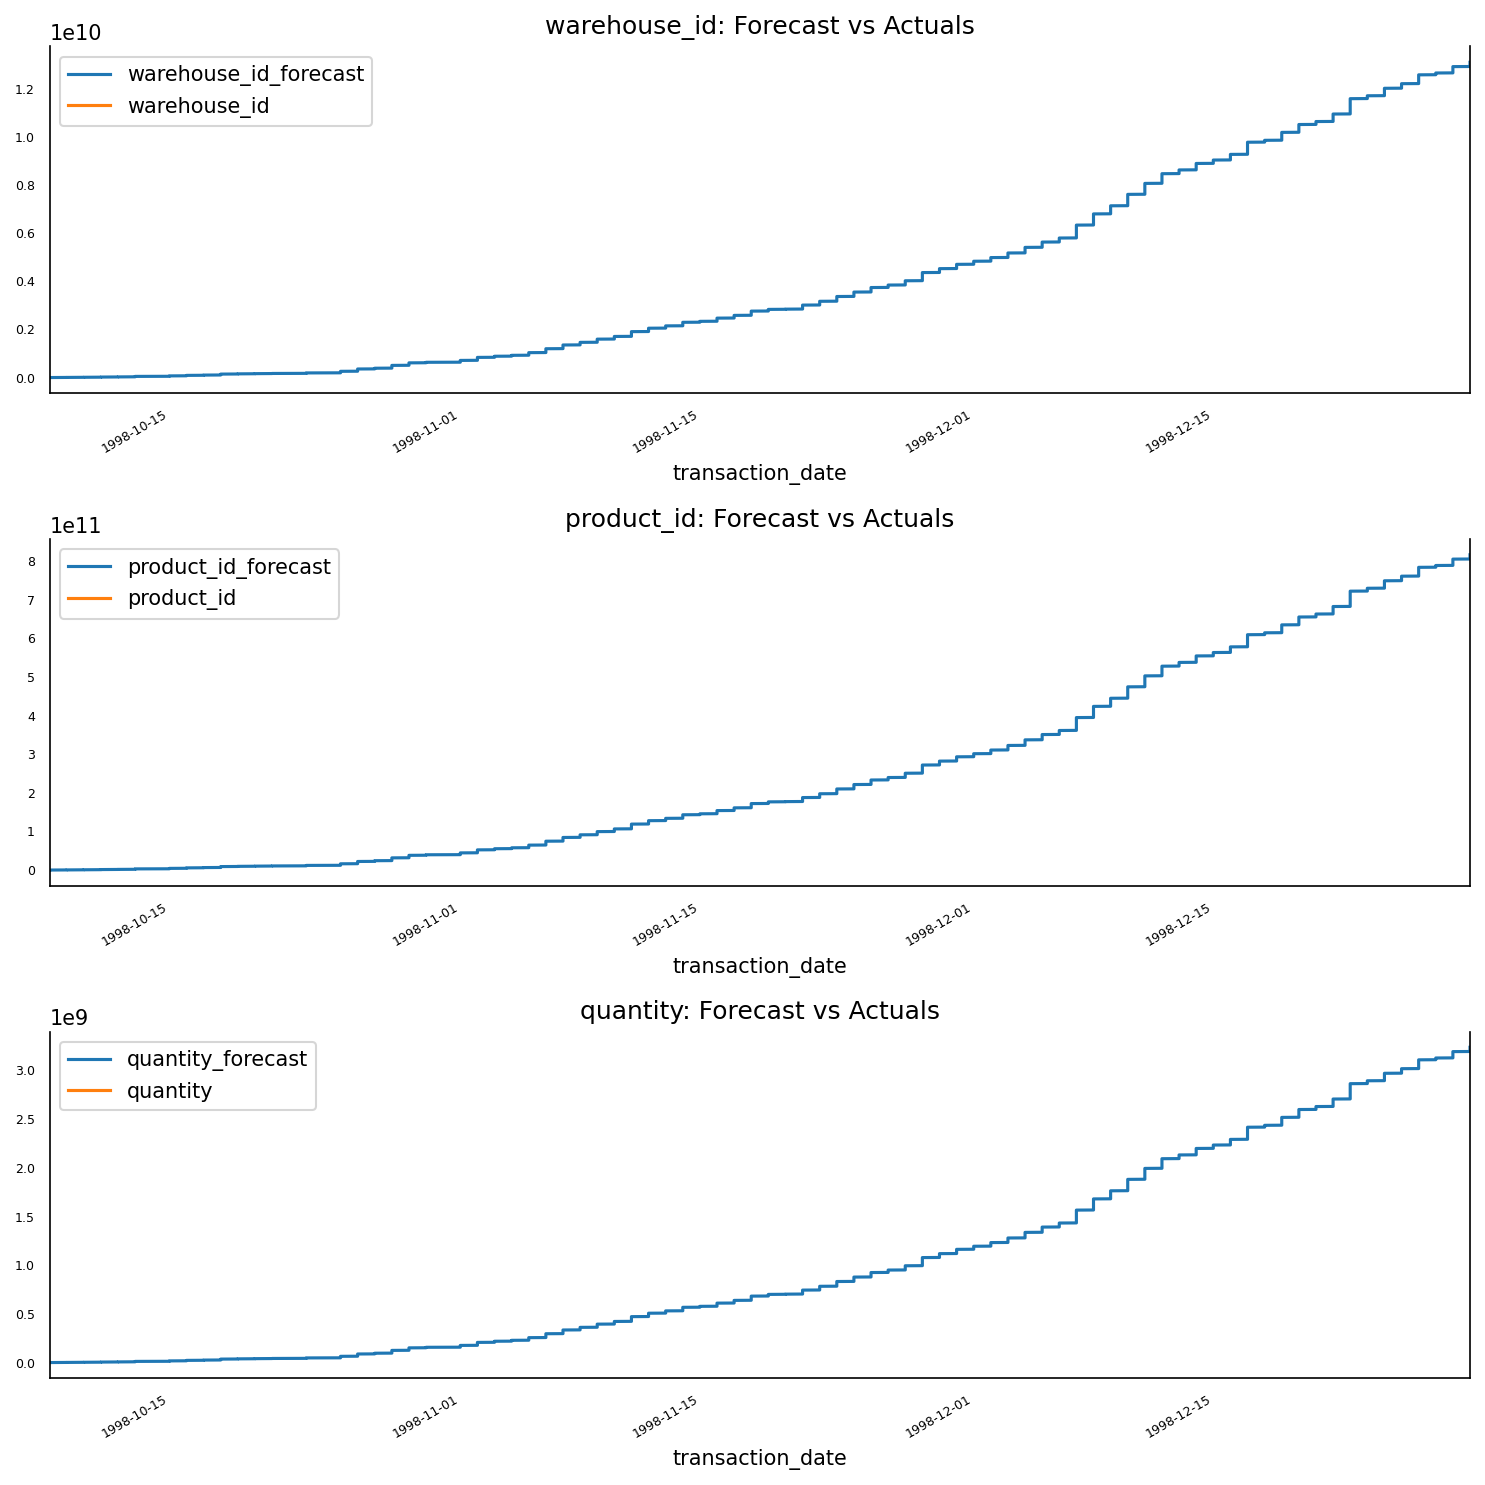

In [75]:
fig, axes = plt.subplots(nrows=int(len(df.columns)), ncols=1, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-3:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### Evaluate the Forecast

In [77]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: Quantity')
accuracy_prod = forecast_accuracy(df_results['quantity_forecast'].values, df_test['quantity'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: product_id')
accuracy_prod = forecast_accuracy(df_results['product_id_forecast'].values, df_test['product_id'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: Ware_house_id')
accuracy_prod = forecast_accuracy(df_results['warehouse_id_forecast'].values, df_test['warehouse_id'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: Quantity
mape :  381750528.0685
me :  1079614635.0652
mae :  1079614635.0652
mpe :  381750528.0685
rmse :  1448429911.6132
corr :  -0.0102
minmax :  1.0

Forecast Accuracy of: product_id
mape :  1173339728.7623
me :  272321440672.0537
mae :  272321440672.0537
mpe :  1173339728.7623
rmse :  365309762865.8068
corr :  0.0012
minmax :  1.0

Forecast Accuracy of: Ware_house_id
mape :  693903720.9448
me :  4369438891.9123
mae :  4369438891.9123
mpe :  693903720.9448
rmse :  5862109354.976
corr :  -0.0258
minmax :  1.0


## Applying ARIMA for each column alone

### FOrecasting the Quantity Column

In [88]:
#auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters
#and chooses the best model that has the least AIC.

model = pm.auto_arima(df.quantity, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=945353.507, Time=1.37 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=568886.377, Time=2.43 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=799990.006, Time=7.74 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=521357.474, Time=5.99 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=500864.796, Time=7.76 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=9.31 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=82.00 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=67.47 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=110.58 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=450736.950, Time=23.44 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=450746.097, Time=16.87 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=450724.015, Time=26.03 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=450713.126, Time=33.36 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=450715.150, Time=98.00 sec
 ARIMA(4,0,1)(0,0,0)[0] 

In [ ]:
#First of all, set the index of the Dataset as Date_Time. Secondly,
#ARIMA works on a univariate series. So you can either deal with each time series individually 
#or use a different forecasting model For multivariate time series, you can use VAR (Vector autoregression) model
#VARMA

C:\Users\alihi\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\alihi\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


0.7247749813328502


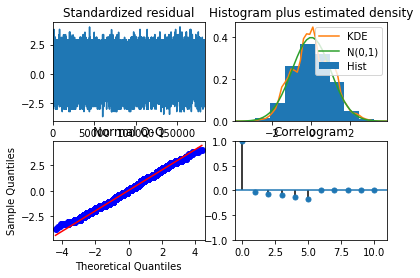

In [79]:
#Model Diagnostic: it is a way to check if the model selected is the best 
#we see the residuals of the model  by mean absolute error , that it should be uncorrelated white noise gaussian , noise centered on zero
# Fit model
model = sm.tsa.statespace.SARIMAX(df.quantity, order=(5,0,0))
results = model.fit()
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))
# Print mean absolute error
print(mae)
results.plot_diagnostics()
plt.show()

In [83]:
# Create Training and Test
train = df.quantity[:137162]
test = df.quantity[137162:]
print(train.head())

transaction_date
1998-01-01    3
1998-01-01    3
1998-01-01    3
1998-01-01    2
1998-01-01    3
Name: quantity, dtype: int64


C:\Users\alihi\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


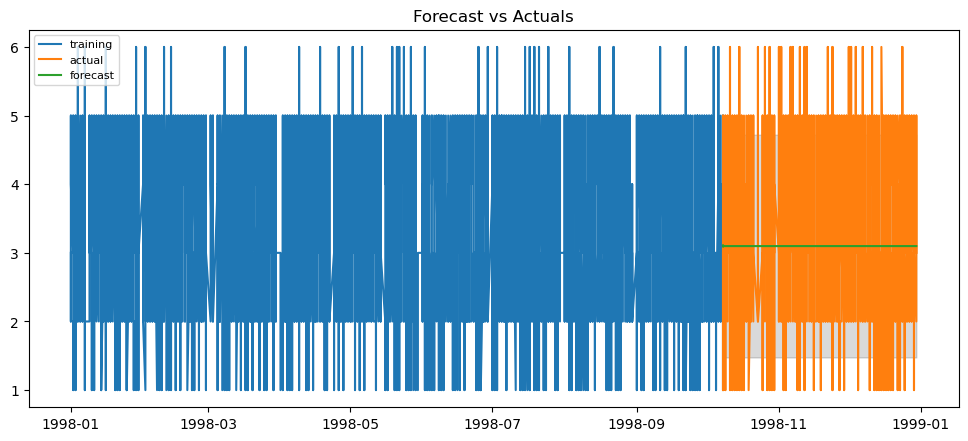

In [84]:
# Build Model, to see if we applied the previous assumed p.d.q how the forecast will be  
# Now we will do the Cross -Validation Times series decomposition

model = ARIMA(train, order=(5, 0, 0))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(45721, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [85]:
print('the predicted ones',fc)
print('the real values are',test.values)

the predicted ones [3.09899579 3.09334219 3.1037211  ... 3.09845273 3.09845273 3.09845273]
the real values are [3 2 4 ... 4 2 3]


In [86]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

# Around 24.4% MAPE implies the model is about 75.6% accurate in predicting the next 45721 observations.

C:\Users\alihi\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'mape': 0.2440737613883346,
 'me': -0.001348064360078419,
 'mae': 0.6394211794919256,
 'mpe': 0.09102074185677214,
 'rmse': 0.8353382857344431,
 'acf1': 0.01355964748326835,
 'corr': 0.007590045448319046,
 'minmax': 0.1794929332788745}

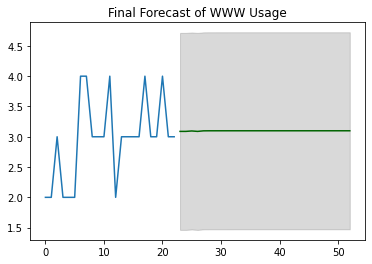

In [91]:
# Forecast
n_periods = 30
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df342.quantity), len(df342.quantity)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df342.quantity)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

### Forecasting the Product_id Column

In [100]:
#auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters
#and chooses the best model that has the least AIC.

model = pm.auto_arima(df.product_id, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3007995.118, Time=1.58 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=1.98 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2773562.539, Time=15.17 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2061363.931, Time=2.69 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2061366.710, Time=25.93 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2061364.670, Time=3.54 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2595805.205, Time=56.46 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=3.56 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2061367.810, Time=49.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2060573.942, Time=8.56 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2536295.831, Time=56.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2060572.923, Time=4.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2752177.531, Time=3.19 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2060573.942, Time=13.46 sec
 

In [ ]:
#First of all, set the index of the Dataset as Date_Time. Secondly,
#ARIMA works on a univariate series. So you can either deal with each time series individually 
#or use a different forecasting model For multivariate time series, you can use VAR (Vector autoregression) model
#VARMA

C:\Users\alihi\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\alihi\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


8.110066187737942


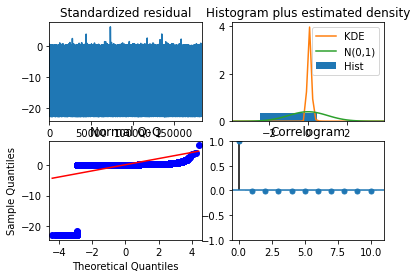

In [93]:
#Model Diagnostic: it is a way to check if the model selected is the best 
#we see the residuals of the model  by mean absolute error , that it should be uncorrelated white noise gaussian , noise centered on zero
# Fit model
model = sm.tsa.statespace.SARIMAX(df.product_id, order=(1,0,0))
results = model.fit()
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))
# Print mean absolute error
print(mae)
results.plot_diagnostics()
plt.show()

In [95]:
# Create Training and Test
train = df.product_id[:137162]
test = df.product_id[137162:]
print(train.head())

transaction_date
1998-01-01     4
1998-01-01    11
1998-01-01    12
1998-01-01    14
1998-01-01    16
Name: product_id, dtype: int64


C:\Users\alihi\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


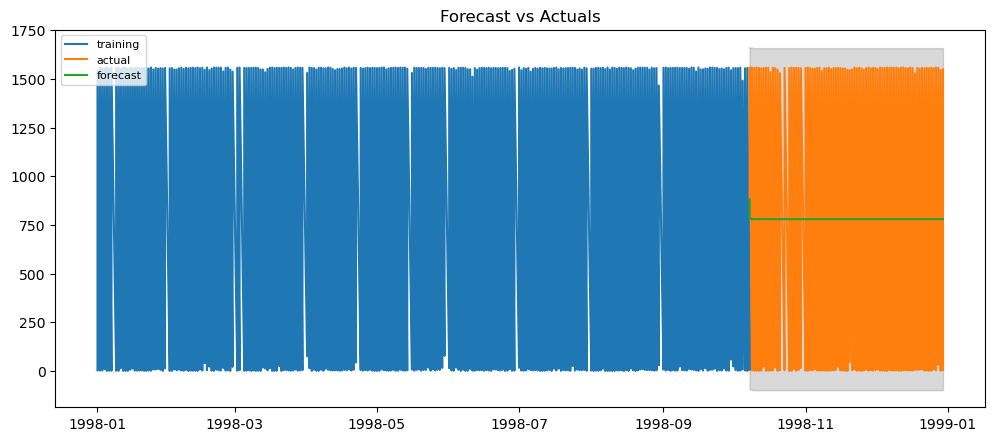

In [96]:
# Build Model, to see if we applied the previous assumed p.d.q how the forecast will be  
# Now we will do the Cross -Validation Times series decomposition

model = ARIMA(train, order=(1, 0, 0))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(45721, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [97]:
print('the predicted ones',fc)
print('the real values are',test.values)

the predicted ones [882.77939797 881.57318639 880.3811956  ... 780.46818178 780.46818178
 780.46818178]
the real values are [ 885  888  890 ... 1542 1544 1549]


In [98]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

# The result of the product id is really bad

C:\Users\alihi\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'mape': 2.730407881736358,
 'me': -9.860877795132147,
 'mae': 390.12292956449215,
 'mpe': 2.4164126880537555,
 'rmse': 449.4167012408837,
 'acf1': 0.989504141020892,
 'corr': 0.03309153486039662,
 'minmax': 0.4006034386715698}

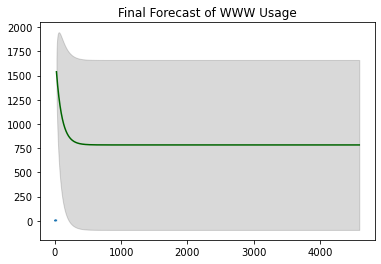

In [101]:
# Forecast
n_periods = 4572
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df342.quantity), len(df342.quantity)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df342.quantity)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

### Forecasting the Ware_house_id 

In [102]:
#auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters
#and chooses the best model that has the least AIC.

model = pm.auto_arima(df.warehouse_id, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1486832.604, Time=2.30 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1262528.110, Time=2.38 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1386122.573, Time=9.77 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1219057.102, Time=2.95 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1199065.774, Time=3.65 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=1188558.184, Time=4.32 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=1181608.863, Time=10.62 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=1156521.569, Time=113.01 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=1156523.490, Time=79.11 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=1156525.998, Time=92.71 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=1156528.044, Time=65.63 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=1156332.959, Time=340.03 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=1156287.984, Time=293.52 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1156440.

In [ ]:
#First of all, set the index of the Dataset as Date_Time. Secondly,
#ARIMA works on a univariate series. So you can either deal with each time series individually 
#or use a different forecasting model For multivariate time series, you can use VAR (Vector autoregression) model
#VARMA

C:\Users\alihi\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\alihi\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\alihi\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


0.6353855336251449


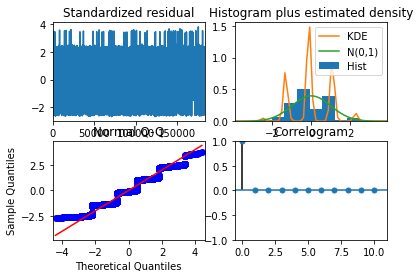

In [103]:
#Model Diagnostic: it is a way to check if the model selected is the best 
#we see the residuals of the model  by mean absolute error , that it should be uncorrelated white noise gaussian , noise centered on zero
# Fit model
model = sm.tsa.statespace.SARIMAX(df.quantity, order=(4,0,1))
results = model.fit()
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))
# Print mean absolute error
print(mae)
results.plot_diagnostics()
plt.show()

In [104]:
# Create Training and Test
train = df.warehouse_id[:137162]
test = df.warehouse_id[137162:]
print(train.head())

transaction_date
1998-01-01    10
1998-01-01    10
1998-01-01    10
1998-01-01    10
1998-01-01    10
Name: warehouse_id, dtype: int64


C:\Users\alihi\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


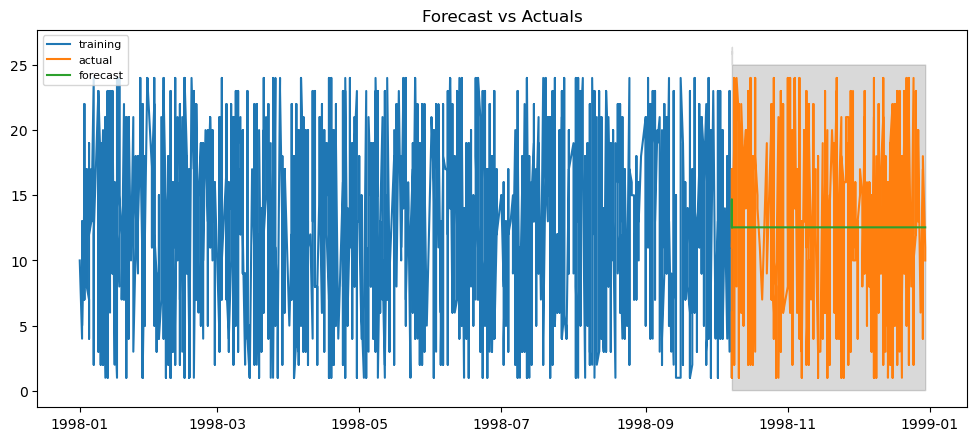

In [105]:
# Build Model, to see if we applied the previous assumed p.d.q how the forecast will be  
# Now we will do the Cross -Validation Times series decomposition

model = ARIMA(train, order=(5, 0, 0))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(45721, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [106]:
print('the predicted ones',fc)
print('the real values are',test.values)

the predicted ones [14.54146322 14.24760474 14.67015364 ... 12.539881   12.539881
 12.539881  ]
the real values are [ 6  1 11 ... 10 10 10]


In [107]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

# Around 24.4% MAPE implies the model is about 75.6% accurate in predicting the next 45721 observations.

C:\Users\alihi\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'mape': 1.1732443266686985,
 'me': -0.07319187538419043,
 'mae': 5.508191403538423,
 'mpe': 0.8903910828432422,
 'rmse': 6.5127268221948,
 'acf1': 0.21548260069272288,
 'corr': -0.009023624164471175,
 'minmax': 0.3581229369312058}

In [ ]:
# Forecast
n_periods = 4572
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df342.quantity), len(df342.quantity)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df342.quantity)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

### Don't run this cells

In [34]:
a = df[['transaction_date']].values
b = df[['warehouse_id']].values
c = df[['product_id']].values
d = df[['quantity']].values

In [38]:
data1 = np.vstack([b, c,d])
print(data1)

#Best model:  ARIMA(5,0,0)(0,0,0)[0] intercept

import numpy as np
from statsmodels.tsa.arima_model import ARIMA

a = [1, 2]
b = [3, 4]
c = [5, 6]
d = [7, 8]

data = np.dstack([a, b, c, d])

print(data.shape)
print(data)

for p in range(4):
    for d in range(1):
        for q in range(2):
            order = (p,d,q)    
            try:
                model = ARIMA(data, order=(p,d,q))
                print("this works:{}, {}, {} ".format(p,d,q))
            except:
                print(order)
                print('reached exception')
                pass

[[10]
 [10]
 [10]
 ...
 [ 4]
 [ 2]
 [ 3]]
